In [1]:
cd ..

/Users/odatakuma/cmu/FleetAI


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import cPickle as pickle
import time
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from engine.simulator import FleetSimulator
import experiment as ex
plt.style.use('ggplot')
from engine.dqn_v3 import Agent

Using TensorFlow backend.


In [3]:
GRAPH_PATH = 'data/pickle/nyc_network_graph.pkl'
TRIP_PATH = 'data/nyc_taxi/trips_2016-05.csv'
ETA_MODEL_PATH = 'data/pickle/triptime_predictor.pkl'
GEOHASH_TABLE_PATH = 'data/table/zones.csv'
AC_NETWORK_PATH = 'data/a3c/saved_networks'

SAMPLE_SIZE = 500000
NUM_FLEETS = 8000
CYCLE = 1
ACTION_UPDATE_CYCLE = 15
DEMAND_CYCLE = 30

In [4]:
with open(GRAPH_PATH, 'r') as f:
    G = pickle.load(f)
    
with open(ETA_MODEL_PATH, 'r') as f:
    eta_model = pickle.load(f)

geohash_table = pd.read_csv(GEOHASH_TABLE_PATH, index_col='geohash')

In [5]:
def plot_state(state, sqrt=True):
    N, Nx, Ny = state.shape
    for i in range(N):
        plt.subplot(1, N, i+1)
        plt.title(i+1)
        if sqrt:
            plt.pcolor(np.arange(Nx+1), np.arange(Ny+1), np.sqrt(state[i].T))
        else:
            plt.pcolor(np.arange(Nx+1), np.arange(Ny+1), state[i].T)
        plt.axis([0, Nx, 0, Ny])
    return plt

In [6]:
env = FleetSimulator(G, eta_model, CYCLE, ACTION_UPDATE_CYCLE)
trips, dayofweek, minofday, duration = ex.load_trips(TRIP_PATH, SAMPLE_SIZE)
num_steps = 1440 / CYCLE
agent = Agent(geohash_table, CYCLE, ACTION_UPDATE_CYCLE, DEMAND_CYCLE, training=False, load_network=True)
# agent = Agent(geohash_table, CYCLE, ACTION_UPDATE_CYCLE, DEMAND_CYCLE, 'global', training=False)

Successfully loaded: data/dqn/saved_networks/duel-13000


In [9]:
for _ in range(10):
    actions = agent.get_actions(vehicles, requests)
    vehicles, requests, _, _, _ = env.step(actions)

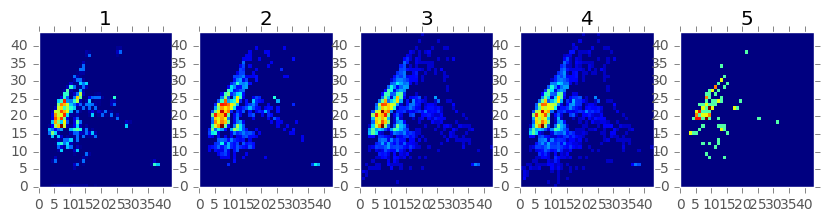

In [10]:
env_state, R_idle = agent.preprocess(vehicles)
plt.figure(figsize=(10, 2))
plot_state(np.array(env_state));

In [50]:
Nx = 43
Ny = 44
xy_idle = [(x, y) for y in range(Ny) for x in range(Nx) if env_state[-1][x, y] > 0]
aux_feature = np.float32(agent.create_aux_feature(agent.minofday, agent.dayofweek, xy_idle))
# aux_feature[:, :, :, :] = 1
main_feature = np.float32(agent.create_main_feature(env_state, xy_idle))
main_feature[:, :, :, :] = 0.1
q_values = agent.sess.run(agent.q_values,
                         feed_dict={agent.s: main_feature, agent.x: aux_feature})

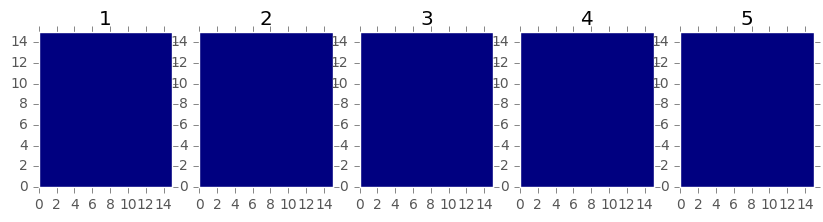

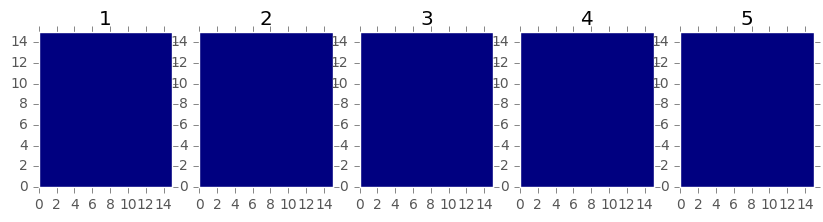

In [51]:
i = 15
x0, y0 = 21, 21
plt.figure(figsize=(10, 2))
plot_state(main_feature[i:i+5, 0, x0:x0+15, y0:y0+15]);
plt.figure(figsize=(10, 2))
plot_state(main_feature[i:i+5, 2, x0:x0+15, y0:y0+15]);

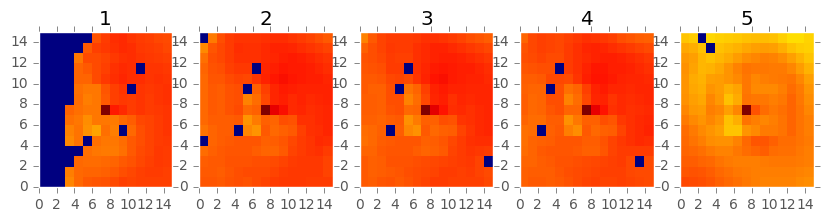

In [52]:
q = q_values.reshape((q_values.shape[0], 15, 15))
plt.figure(figsize=(10, 2))
plot_state(q[i:i+5], sqrt=False);

In [53]:
np.argmax(q_values, 1)

array([112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 112])

In [7]:
import tensorflow as tf

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [8]:
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global'))
checkpoint = tf.train.get_checkpoint_state(AC_NETWORK_PATH)
if checkpoint and checkpoint.model_checkpoint_path:
    saver.restore(sess, checkpoint.model_checkpoint_path)
    print('Successfully loaded: ' + checkpoint.model_checkpoint_path)

Successfully loaded: data/a3c/saved_networks/ac-500


In [9]:
agent.build_d_network()

In [7]:
env.reset(NUM_FLEETS, trips, dayofweek, minofday)
vehicles, requests, _, _, _ = env.step()
agent.reset(requests, env.dayofweek, env.minofday)

In [8]:
for _ in range(10):
    actions, _ = agent.get_actions(vehicles, requests, sess)
    vehicles, requests, _, _, _ = env.step(actions)

NameError: name 'sess' is not defined

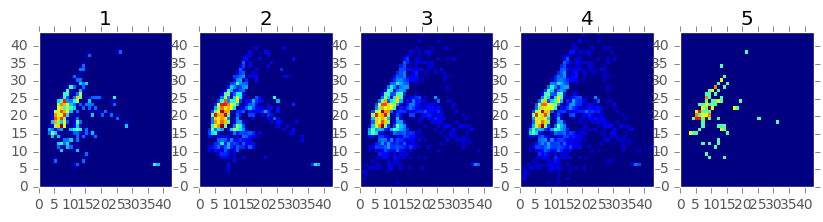

In [12]:
env_state, R_idle = agent.preprocess(vehicles)
plt.figure(figsize=(10, 2))
plot_state(np.array(env_state));

In [13]:
Nx = 43
Ny = 44
xy_idle = [(x, y) for y in range(Ny) for x in range(Nx) if env_state[-1][x, y] > 0]
aux_feature = np.float32(agent.create_aux_feature(agent.minofday, agent.dayofweek, xy_idle))
# aux_feature[:, :, :, :] = 1
main_feature = np.float32(agent.create_main_feature(env_state, xy_idle))
a_dist, V = sess.run([agent.policy, agent.value],
                         feed_dict={agent.main_input: main_feature, agent.aux_input: aux_feature})

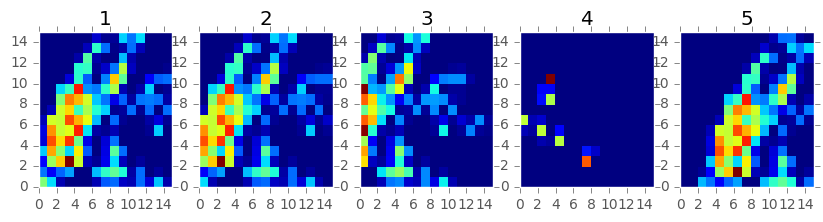

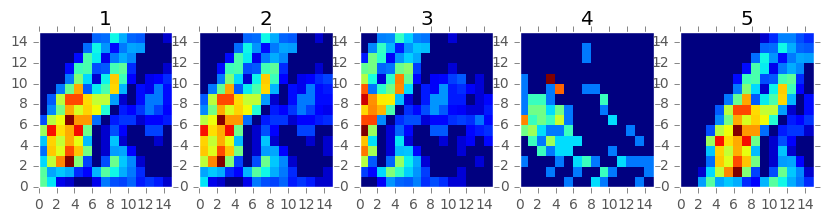

In [14]:
i = 25
x0, y0 = 21, 21
plt.figure(figsize=(10, 2))
plot_state(main_feature[i:i+5, 0, x0:x0+15, y0:y0+15]);
plt.figure(figsize=(10, 2))
plot_state(main_feature[i:i+5, 2, x0:x0+15, y0:y0+15]);

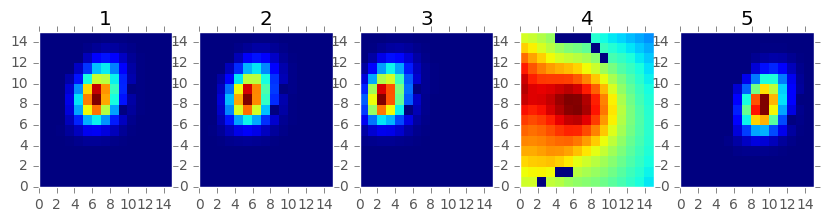

In [15]:
pi = a_dist.reshape((a_dist.shape[0], 15, 15))
plt.figure(figsize=(10, 2))
plot_state(pi[i:i+5], sqrt=True);